# This notebook simulates FMCW radar signals using Infineon 60 GHz parameters.

It generates:
- Chirp-level beat signals  
- Range profiles  
- Range–Doppler maps (RDM)  

# Imports & Parameters

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import hann

c = 3e8
fc = 60e9
B = 240e6
T_chirp = 60e-6
fs = 2e6
N_samples = max(256, int(T_chirp * fs))
N_chirps = 64
S = B / T_chirp
range_res = c / (2 * B)

print("N_samples:", N_samples, "N_chirps:", N_chirps, "range_res (m):", range_res)

N_samples: 256 N_chirps: 64 range_res (m): 0.625


# Simulation Functions

In [10]:
def generate_target_echo(range_m, vel_m_s, rcs=1.0, snr_db=20):
    lam = c / fc
    f_b = 2 * S * range_m / c
    f_d = 2 * vel_m_s / lam
    t_fast = np.arange(N_samples) / fs
    data = np.zeros((N_chirps, N_samples), dtype=np.complex64)
    amp = rcs / (range_m**2 + 1e-6)

    for n in range(N_chirps):
        doppler_phase = np.exp(1j * 2*np.pi * f_d * (n*T_chirp))
        beat = np.exp(1j * 2*np.pi * f_b * t_fast)
        data[n, :] = amp * doppler_phase * beat

    sig_pow = np.mean(np.abs(data)**2)
    snr_lin = 10**(snr_db/10)
    noise_pow = sig_pow / (snr_lin + 1e-12)
    noise = np.sqrt(noise_pow/2) * (np.random.randn(*data.shape) + 1j*np.random.randn(*data.shape))

    return data + noise

def simulate_scene(targets):
    scene = np.zeros((N_chirps, N_samples), dtype=np.complex64)
    for t in targets:
        scene += generate_target_echo(t['r'], t['v'], t['rcs'], t['snr_db'])
    return scene


# Range FFT + RD Map

In [11]:
def compute_range_doppler(scene):
    win = hann(N_samples)
    scene_win = scene * win[np.newaxis, :]

    R = np.fft.fft(scene_win, axis=1)
    R_pos = R[:, :N_samples//2]

    RD = np.fft.fft(R_pos, axis=0)
    RD_shift = np.fft.fftshift(RD, axes=0)

    RD_mag = np.abs(RD_shift)
    RD_db = 20 * np.log10(RD_mag + 1e-12)

    return RD_db, R_pos


# Simulate a Scene

In [12]:
targets = [
    {'r': 5.0, 'v': 0.0, 'rcs': 3.0, 'snr_db': 30},
    {'r': 8.5, 'v': -1.1, 'rcs': 1.2, 'snr_db': 20},
    {'r': 12.0, 'v': 0.0, 'rcs': 0.6, 'snr_db': 10}
]

scene = simulate_scene(targets)
print("Scene shape:", scene.shape)


Scene shape: (64, 256)


# Compute RD & Range Profile

In [13]:
RD_db, Rpos = compute_range_doppler(scene)
range_profile = np.abs(np.fft.fft(scene, axis=1)).mean(axis=0)[:N_samples//2]

# Plot everything

Text(0.5, 0, 'Fast-time Samples')

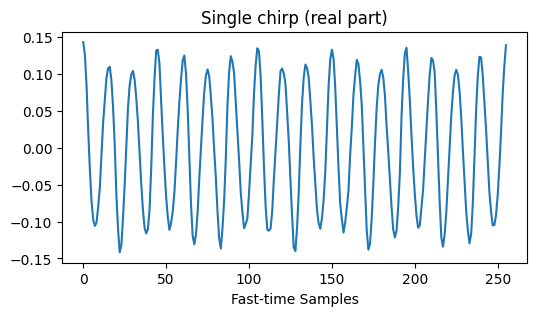

In [15]:
plt.figure(figsize=(6,3))
plt.plot(scene[0].real)
plt.title('Single chirp (real part)')
plt.xlabel('Fast-time Samples')

Text(0.5, 0, 'Range bin')

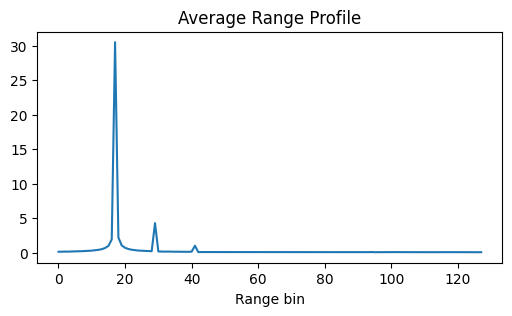

In [16]:
plt.figure(figsize=(6,3))
plt.plot(range_profile)
plt.title('Average Range Profile')
plt.xlabel('Range bin')

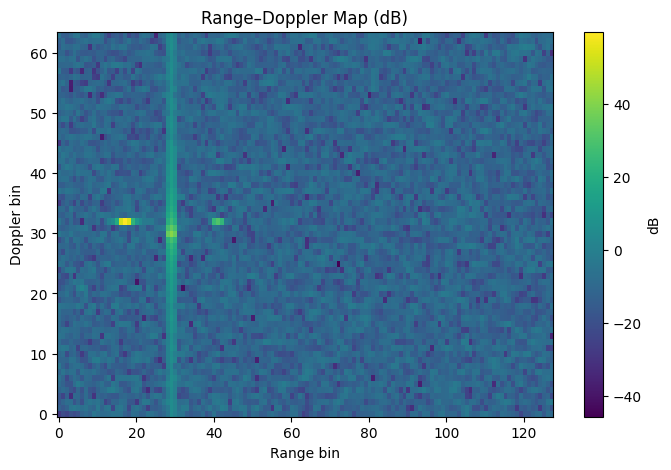

In [17]:
plt.figure(figsize=(8,5))
plt.imshow(RD_db, aspect='auto', origin='lower')
plt.title('Range–Doppler Map (dB)')
plt.xlabel('Range bin')
plt.ylabel('Doppler bin')
plt.colorbar(label='dB')
plt.show()